In [1]:
%clear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares

%matplotlib inline

mpl.rcParams['figure.dpi']=100
mpl.rcParams['figure.titlesize']=20
mpl.rcParams['axes.facecolor']='white'        
mpl.rcParams['lines.linewidth']=2.0
mpl.rcParams['axes.linewidth']=2.0
mpl.rcParams['xtick.major.pad']=6
mpl.rcParams['ytick.major.pad']=6
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['axes.titlesize']=18
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['axes.grid']='True'
mpl.rcParams['axes.axisbelow']='line'
mpl.rcParams['legend.fontsize']=12

In [2]:
def ode_Lin_model_Act (S, t, p):
    C0=S[0]
    C1=S[1]
    C2=S[2]
    C3=S[3]
    C4=S[4]
    I0=S[5]
    I1=S[6]
    I2=S[7]
    I3=S[8]
    I4=S[9]
    O =S[10]

    
    #constants
    
    T = 291.0 #K or 18 degree celsius
    e =  1.602176634 * (10**-19.0) # C
    K_B = 1.380649 * (10**-23.0) # J*K^-1
    
    exp_factor = (e/(K_B * T)) * (10**-3) 

    #Voltage sequences
    
    V = 0.0 #mV 

    if 0 <= t < 0.5:
        V = -90.0 # mV
        
    if 0.5 <= t < 0.55:
#        V = p[11] # Vtest
        V = p[8]
        
    if 0.55 <= t <= 1.05:
        V = -50.0 # mV
        
    if t > 1.05 :
        V = -50.0 #mV
 


    # wild type parameters
#    alpha_0 = 450.0 #s^-1
#    alpha_1 = 0.23 #s^-1
    
#    beta_0 = 2.0 #s^-1
#    beta_1 = 2.2 #s^-1
    
#    k_CO_0 = 160.0 #s^-1
#    k_CO_1 = 0.27 #s^-1
    
#    k_OC_0 = 245.0 #s^-1
#    k_OC_1 = 0.33 #s^-1
    
    k_CI = 25.00 #s^-1
    k_IC = 0.30 #s^-1
    
    f = 0.37

#    k_CI = p[8]
    
#    k_IC = p[9]

#    f = p[10]
    
    #voltage dependent rate constants
    
    #alpha = alpha_0 * np.exp(alpha_1 * (V * exp_factor))
    #beta = beta_0 * np.exp(-1.0 * beta_1 * (V * exp_factor))
    #k_CO = k_CO_0 * np.exp(k_CO_1 * (V * exp_factor))
    #k_OC = k_OC_0 * np.exp(-1.0 * k_OC_1 * (V * exp_factor))
    
     
    alpha = p[0] * np.exp(p[1] * (V * exp_factor))
    beta = p[2] * np.exp(-1.0 * p[3] * (V * exp_factor))
    k_CO = p[4] * np.exp(p[5] * (V * exp_factor))
    k_OC = p[6] * np.exp(-1.0 * p[7] * (V * exp_factor))
    
    # ODEs
    
    dC0dt = beta * C1 + (k_IC/(f**4.0)) * I0 - (k_CI*(f**4.0) + 4.0 * alpha) * C0
    dC1dt = 4.0 * alpha * C0 + 2.0 * beta * C2 + (k_IC/(f**3.0)) * I1 - (k_CI*(f**3.0) + beta + 3.0 * alpha) * C1 
    dC2dt = 3.0 * alpha * C1 + 3.0 * beta * C3 + (k_IC/(f**2.0)) * I2 - (k_CI*(f**2.0) + 2.0 * beta + 2.0 * alpha) * C2 
    dC3dt = 2.0 * alpha * C2 + 4.0 * beta * C4 + (k_IC/f) * I3 - (k_CI*f + 3.0 * beta + 1.0 * alpha) * C3 
    dC4dt = 1.0 * alpha * C3 + k_OC * O + k_IC * I4 - (k_CI + k_CO + 4.0 * beta) * C4 
    
    dI0dt = beta * f * I1 + (k_CI*(f**4.0)) * C0 - (k_IC/(f**4.0) + 4.0 * (alpha/f)) * I0
    dI1dt = 4.0 * (alpha/f) * I0 + 2.0 * beta * f * I2 + (k_CI*(f**3.0)) * C1 - (k_IC/(f**3.0) + beta * f + 3.0 * (alpha/f)) * I1 
    dI2dt = 3.0 * (alpha/f) * I1 + 3.0 * beta * f * I3 + (k_CI*(f**2.0)) * C2 - (k_IC/(f**2.0) + 2.0 * beta * f + 2.0 * (alpha/f)) * I2 
    dI3dt = 2.0 * (alpha/f) * I2 + 4.0 * beta * f * I4 + (k_CI*f) * C3 - (k_IC/f + 3.0 * beta * f + 1.0 * (alpha/f)) * I3 
    dI4dt = 1.0 * (alpha/f) * I3 + k_CI * C4 - (k_IC + 4.0 * beta * f) * I4     
    
    dOdt = k_CO * C4 - k_OC * O
    
    return (dC0dt, dC1dt, dC2dt, dC3dt, dC4dt, dI0dt, dI1dt, dI2dt, dI3dt, dI4dt, dOdt)

In [3]:
def Act_Protocol(max_V, DeltaV):
    Vhold = -90.0 #mV
    
    Vtest = np.linspace(Vhold,max_V,np.abs(np.int((max_V-Vhold)/DeltaV))+1)
    
    return Vtest #array of testing voltages

In [4]:
def Boltz_eq(x, V1_2, k):
    return 1.0/(1.0 + np.exp(-(x-V1_2)/k))

In [5]:
def act_LS_func(x, teta):

    # conductance parameters

    #EK      = 0.0    # mV
    gK_max  = 33.2     # nS 

    # Assuming no leaking
    #EL      = 0.0    # mV
    #gL_max  = 0.0    # mS 

    # Membrane capacitance
    Cm      = 1.0    # microF cm^-2
    
    #define activation sequence protocol
    
    Vmax = 60.0 #mV
    
    increment = 10.0 #mV
    
    Vtest = Act_Protocol(Vmax, increment)
    
    # Time discretiztion
    tini = 0.0
    
    tend = 1.05
    
    ttest = 0.56 #time at which you start record the current
     
    Npoints = 100000
    
    Points_per_sec = np.int(Npoints/tend) 
    
    # time array
    #t = np.linspace(tini,tend,Npoints)

    # prepare empty arrays
    Open_states = np.zeros((Npoints,len(Vtest)))

    max_conductance = np.zeros(len(Vtest)) 

    
    for i in range (0,len(Vtest)):
        gamma = np.append(teta, Vtest[i])
        
        f = lambda S,t: ode_Lin_model_Act(S, t, gamma)
        
        r = odeint(f, S0, x)
        
        Open_states[:,i] = r[:,10]
        
        max_conductance[i] = gK_max * np.amax(r[np.int(Points_per_sec*ttest):,10])
    
    
    g_gmax = (max_conductance-np.amin(max_conductance))/(np.amax(max_conductance)-np.amin(max_conductance))
    
    return g_gmax

In [6]:
def residual_Act(p):
    
    #define activation sequence protocol
    
    Vmax = 60.0 #mV
    
    increment = 10.0 #mV
    
    Vtest = Act_Protocol(Vmax, increment)
    
    #experimental data for hemiactivation and slope
    
    exp_Vhemi_act = -22.70 #mV
    
    exp_k_act = 13.00 #mV
    
    #evaluation of experimental points trough the declared Boltzmann fit
    
    exp_data = Boltz_eq(Vtest,exp_Vhemi_act,exp_k_act)
    
    # Time discretiztion
    tini = 0.0
    
    tend = 1.05
    
    ttest = 0.56 #time at which you start record the current
     
    Npoints = 100000
    
    Points_per_sec = np.int(Npoints/tend) 
    
    # time array
    t = np.linspace(tini,tend,Npoints)
    
    err = exp_data - act_LS_func(t,p)
    
    return err

In [114]:
# Main 

# Guess of initial conditions for the states 
C0_0=0.4390
C1_0=0.2588
C2_0=0.0572
C3_0=0.0056
C4_0=0.0002
I0_0=0.0128
I1_0=0.0553
I2_0=0.0894
I3_0=0.0642
I4_0=0.0172
O_0=0.0001

# Pack up the initial conditions:

S0 = [C0_0, C1_0, C2_0, C3_0, C4_0, I0_0, I1_0, I2_0, I3_0, I4_0, O_0]

# guess of the transition rates and other ODEs params (start from Lin Model)

#guess = [450.0, 0.23, 2.0, 2.2, 160.0, 0.27, 245, 0.33, 25.0, 0.3, 0.37]

#guess = [600.0, 0.28, 70.0, 2.4, 280.2, 0.35, 60.23, 0.27]

guess = [690.87, 0.252, 45.32, 2.22, 326.15, 0.386, 50.48, 0.30]

# set boundaries for parameters lsq fitting based on physical reasoning

#boundaries = ([0,0,0,0,0,0,0,0,0,0,0],[1000,100,1000,100,1000,100,1000,100,1000,100,1])

boundaries = ([400,0,0,0,100,0,0,0],[1000,1,200,10,400,1,100,1])

# Run the optimization for the cost function 

#result_lm = least_squares(residual_Act, guess, method='lm', max_nfev=15000)

result_trf = least_squares(residual_Act, guess, bounds=boundaries, method='trf',tr_solver='lsmr',max_nfev=500000)


In [115]:
#print result_lm.x
print result_trf.x
print result_trf.cost
print result_trf.optimality
print result_trf.fun

[6.91385408e+02 2.45662141e-01 4.53997037e+01 2.22674457e+00
 3.25224170e+02 3.69604129e-01 5.01260240e+01 3.03052420e-01]
0.10484650320911289
15.05228686601859
[ 0.00560892  0.01203238  0.02561618  0.05369573  0.10909224  0.20313732
  0.2716557   0.17102216  0.10757049  0.10743815  0.10616906  0.09151629
  0.06869338  0.04357454  0.01959855 -0.00172373]


## Avoid Local Minima with random kick

In [96]:
from random import seed
from random import randint
from datetime import datetime


seed(np.int(datetime.now().strftime("%f")))

tmp = np.zeros(len(result_trf.x))

old_guess = result_trf.x

new_guess = np.zeros(len(result_trf.x))

epsilon = 100.0

while(epsilon > 1.0):

    for i in range(0,len(result_trf.x)):
    
        tmp[i] = old_guess[i] + ((-1.0)**(randint(0,99))) * result_trf.x[i] / (1.0*(randint(1,100)))
    

    results = least_squares(residual_Act, tmp, bounds=boundaries, method='trf',tr_solver='lsmr')  

    new_guess = results.x
    
    epsilon = np.sum(np.abs(np.subtract(new_guess,old_guess)))
    
    print new_guess
    
    print "The epsilon is"
    print epsilon
    
    new_guess = old_guess

    

[181.88163032   0.29241341 249.97621608   0.29877374]
The epsilon is
6.885804133680487


KeyboardInterrupt: 

In [ ]:
x0=np.linspace(-90,60,1000)

plt.figure()
plt.plot(x0, Boltz_eq(x0, -22.70, 13.00), label='Fitted function')

plt.legend(loc='best')

plt.show()

## Inactivation part

In [42]:
def ode_Lin_model_Inact (S, t, p):
    C0=S[0]
    C1=S[1]
    C2=S[2]
    C3=S[3]
    C4=S[4]
    I0=S[5]
    I1=S[6]
    I2=S[7]
    I3=S[8]
    I4=S[9]
    O =S[10]

    
    #constants
    
    T = 291.0 #K or 18 degree celsius
    e =  1.602176634 * (10**-19.0) # C
    K_B = 1.380649 * (10**-23.0) # J*K^-1
    
    exp_factor = (e/(K_B * T)) * (10**-3) 

    #Voltage sequences
    
    V = 0.0 #mV 

    if 0 <= t < 1.0:
        V = -90.0 # mV
        
    if 1.0 <= t < 2.0:
        V = p[11] # Vpre
        
    if 2.0 <= t <= 3.0:
        V = 60.0 # mV Vtest
        
    if t > 3.0 :
        V = 60.0 #mV
 


    # wild type parameters
#    alpha_0 = 450.0 #s^-1
#    alpha_1 = 0.23 #s^-1
    
#    beta_0 = 2.0 #s^-1
#    beta_1 = 2.2 #s^-1
    
#    k_CO_0 = 160.0 #s^-1
#    k_CO_1 = 0.27 #s^-1
    
#    k_OC_0 = 245.0 #s^-1
#    k_OC_1 = 0.33 #s^-1
    
#    k_CI = 25.0 #s^-1
#    k_IC = 0.3 #s^-1
    
#    f = 0.37

    k_CI = p[8]
    
    k_IC = p[9]

    f = p[10]
    
    #voltage dependent rate constants
    
    #alpha = alpha_0 * np.exp(alpha_1 * (V * exp_factor))
    #beta = beta_0 * np.exp(-1.0 * beta_1 * (V * exp_factor))
    #k_CO = k_CO_0 * np.exp(k_CO_1 * (V * exp_factor))
    #k_OC = k_OC_0 * np.exp(-1.0 * k_OC_1 * (V * exp_factor))
    
     
    alpha = p[0] * np.exp(p[1] * (V * exp_factor))
    beta = p[2] * np.exp(-1.0 * p[3] * (V * exp_factor))
    k_CO = p[4] * np.exp(p[5] * (V * exp_factor))
    k_OC = p[6] * np.exp(-1.0 * p[7] * (V * exp_factor))
    
    # ODEs
    
    dC0dt = beta * C1 + (k_IC/(f**4.0)) * I0 - (k_CI*(f**4.0) + 4.0 * alpha) * C0
    dC1dt = 4.0 * alpha * C0 + 2.0 * beta * C2 + (k_IC/(f**3.0)) * I1 - (k_CI*(f**3.0) + beta + 3.0 * alpha) * C1 
    dC2dt = 3.0 * alpha * C1 + 3.0 * beta * C3 + (k_IC/(f**2.0)) * I2 - (k_CI*(f**2.0) + 2.0 * beta + 2.0 * alpha) * C2 
    dC3dt = 2.0 * alpha * C2 + 4.0 * beta * C4 + (k_IC/f) * I3 - (k_CI*f + 3.0 * beta + 1.0 * alpha) * C3 
    dC4dt = 1.0 * alpha * C3 + k_OC * O + k_IC * I4 - (k_CI + k_CO + 4.0 * beta) * C4 
    
    dI0dt = beta * f * I1 + (k_CI*(f**4.0)) * C0 - (k_IC/(f**4.0) + 4.0 * (alpha/f)) * I0
    dI1dt = 4.0 * (alpha/f) * I0 + 2.0 * beta * f * I2 + (k_CI*(f**3.0)) * C1 - (k_IC/(f**3.0) + beta * f + 3.0 * (alpha/f)) * I1 
    dI2dt = 3.0 * (alpha/f) * I1 + 3.0 * beta * f * I3 + (k_CI*(f**2.0)) * C2 - (k_IC/(f**2.0) + 2.0 * beta * f + 2.0 * (alpha/f)) * I2 
    dI3dt = 2.0 * (alpha/f) * I2 + 4.0 * beta * f * I4 + (k_CI*f) * C3 - (k_IC/f + 3.0 * beta * f + 1.0 * (alpha/f)) * I3 
    dI4dt = 1.0 * (alpha/f) * I3 + k_CI * C4 - (k_IC + 4.0 * beta * f) * I4     
    
    dOdt = k_CO * C4 - k_OC * O
    
    return (dC0dt, dC1dt, dC2dt, dC3dt, dC4dt, dI0dt, dI1dt, dI2dt, dI3dt, dI4dt, dOdt)

In [43]:
def Inact_Protocol(max_V, DeltaV):
    Vhold = -90.0 #mV
    
    Vprep = np.linspace(Vhold,max_V,np.abs(np.int((max_V-Vhold)/DeltaV))+1)
    
    return Vtest #array of testing voltages

In [44]:
def Boltz_eq_rev(x, V1_2, k):
    return 1.0/(1.0 + np.exp((x-V1_2)/k))

In [45]:
def Inact_LS_func(x, teta):

    # conductance parameters

    #EK      = 0.0    # mV
    gK_max  = 33.2     # nS 

    # Assuming no leaking
    #EL      = 0.0    # mV
    #gL_max  = 0.0    # mS 

    # Membrane capacitance
    Cm      = 1.0    # microF cm^-2
    
    #define activation sequence protocol
    
    Vmax = 60.0 #mV
    
    increment = 10.0 #mV
    
    Vtest = Inact_Protocol(Vmax, increment)
    
    # Time discretiztion
    tini = 0.0
    
    tend = 3.00
    
    ttest = 2.00 #time at which you start record the current
     
    Npoints = 100000
    
    Points_per_sec = np.int(Npoints/tend) 
    
    # time array
    #t = np.linspace(tini,tend,Npoints)

    # prepare empty arrays
    Open_states = np.zeros((Npoints,len(Vtest)))

    max_conductance = np.zeros(len(Vtest)) 

    max_currents = np.zeros(len(Vtest))
    
    for i in range (0,len(Vtest)):
        gamma = np.append(teta, Vtest[i])
        
        f = lambda S,t: ode_Lin_model_Inact(S, t, gamma)
        
        r = odeint(f, S0, x)
        
        Open_states[:,i] = r[:,10]
        
        max_conductance[i] = gK_max * np.amax(r[np.int(Points_per_sec*ttest):,10])
    
        max_currents[i] = max_conductance[i] * (Vtest[i] + 90.0)
        
    I_Imax = (max_currents-np.amin(max_currents))/(np.amax(max_currents)-np.amin(max_currents))
    
    return I_Imax

In [46]:
def residual_Inact(p):
    
    #define activation sequence protocol
    
    Vmax = 60.0 #mV
    
    increment = 10.0 #mV
    
    Vtest = Inact_Protocol(Vmax, increment)
    
    #experimental data for hemiactivation and slope
    
    exp_Vhemi_inact = -49.60 #mV
    
    exp_k_inact = 5.10 #mV
    
    #evaluation of experimental points trough the declared Boltzmann fit
    
    exp_data = Boltz_eq_rev(Vtest,exp_Vhemi_inact,exp_k_inact)
    
    # Time discretiztion
    tini = 0.0
    
    tend = 3.00
    
    ttest = 2.00 #time at which you start record the current
     
    Npoints = 100000
    
    Points_per_sec = np.int(Npoints/tend) 
    
    # time array
    t = np.linspace(tini,tend,Npoints)
    
    err = exp_data - Inact_LS_func(t,p)
    
    return err

In [56]:
# Main 

# Guess of initial conditions for the states 
C0_0=0.4390
C1_0=0.2588
C2_0=0.0572
C3_0=0.0056
C4_0=0.0002
I0_0=0.0128
I1_0=0.0553
I2_0=0.0894
I3_0=0.0642
I4_0=0.0172
O_0=0.0001

# Pack up the initial conditions:

S0 = [C0_0, C1_0, C2_0, C3_0, C4_0, I0_0, I1_0, I2_0, I3_0, I4_0, O_0]

# guess of the transition rates and other ODEs params (start from Lin Model)

guess = [450.0, 0.23, 2.0, 2.2, 160.0, 0.27, 245, 0.33, 25.0, 0.3, 0.37]

# set boundaries for parameters lsq fitting based on physical reasoning

boundaries = ([0,0,0,0,0,0,0,0,0,0,0],[1000,100,1000,100,1000,100,1000,100,1000,100,1])

# Run the optimization for the cost function 

result_lm = least_squares(residual_Act, guess, method='lm')

result_trf = least_squares(residual_Act, guess, bounds=boundaries, method='trf',tr_solver='lsmr')


In [57]:
print result_lm.x
print result_trf.x

[4.21333138e+02 2.11568341e-01 2.05468996e+00 2.48666474e+00
 1.55107612e+02 2.77648127e-01 2.25205967e+02 3.09919190e-01
 2.45749955e+01 2.79024399e-01 3.93584801e-01]
[4.51876441e+02 2.53299962e-01 2.03478926e+00 2.24985233e+00
 1.59091025e+02 2.47910146e-01 2.43489546e+02 3.08407149e-01
 2.49415382e+01 2.88609910e-01 3.58681676e-01]


### Plot the results

In [62]:
# conductance parameters

#EK      = 0.0    # mV
gK_max  = 33.2     # nS 

# Assuming no leaking
#EL      = 0.0    # mV
#gL_max  = 0.0    # mS 

# Membrane capacitance
Cm      = 1.0    # microF cm^-2

tini_eq = 0
tend = 3.0 
# Time discretiztion
Npoints = 100000
Points_per_sec = np.int(Npoints/tend) 


# time array
t = np.linspace(tini_eq,tend,Npoints)

# Guess of initial conditions for the states 

C0_0=0.4390
C1_0=0.2588
C2_0=0.0572
C3_0=0.0056
C4_0=0.0002
I0_0=0.0128
I1_0=0.0553
I2_0=0.0894
I3_0=0.0642
I4_0=0.0172
O_0=0.0001

# Pack up the parameters and initial conditions:

z0 = [C0_0, C1_0, C2_0, C3_0, C4_0, I0_0, I1_0, I2_0, I3_0, I4_0, O_0]

steps = np.abs(np.int((-90.0-60.0)/10.0)) + 1

Open_states = np.zeros((Npoints,steps))

max_conductance = np.zeros(steps) 

max_currents = np.zeros(steps)

for i in range(0,steps):
    
    
    # Define Potential function (To be improved if one wants to do IV, deactivation, inactivation or recovery)
    Vtest = -90.0 + i * 10.0

    ode_params = result_lm.x
    
    K = np.append(ode_params,Vtest)

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Call for the ODE integrator with initial conditions z0 and parameter K
    C = odeint(ode_Lin_model_Inact, z0, t, args=(K,))

    Open_states[:,i] = C[:,10]
      
    max_conductance[i] = gK_max * np.amax(C[np.int(Points_per_sec*2.0):,10])
    
    # Compute the current proportional to the open channel conductance and potential applied
    
    #max_currents[i] = max_conductance[i] * (Vtest + 90.0)
    
    #I = gK_max * C[:,10] * (V[:] - Vhold) # nS * mV = pA


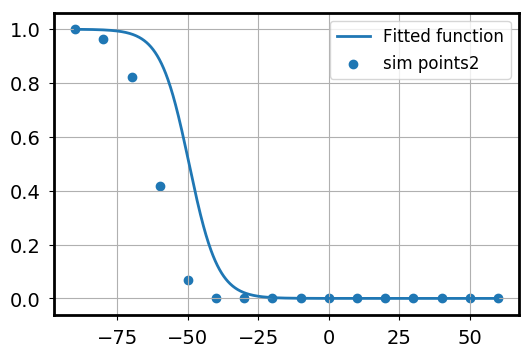

In [63]:
x0=np.linspace(-90,60,1000)
V=np.linspace(-90,60,16)

g_gmax=(max_conductance-np.amin(max_conductance))/(np.amax(max_conductance)-np.amin(max_conductance))
#I_Imax = (max_currents-np.amin(max_currents))/(np.amax(max_currents)-np.amin(max_currents))
fig = plt.figure()
plt.scatter(V,g_gmax, label='sim points2')
#plt.scatter(V,I_Imax, label='sim points')
plt.plot(x0, Boltz_eq_rev(x0, -49.60, 5.10), label='Fitted function')

plt.legend(loc='best')

plt.show()